# Encoder LSTM과 Decoder LSTM으로 스마트 번역기 만들기

In [49]:
# 1. Package Import
import numpy as np
import pandas as pd
from time import time

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model          # 병렬처리
from tensorflow.keras.utils import to_categorical  # One-Hot Encoding

# hyper parameter
# 정확도나 속도에 영향을 미치는 값
MY_HIDDEN = 128 # LSTM의 units 차원
MY_EPOCH  = 500 # 반복 학습 수(fit)

In [16]:
# 2. 번역 데이터 불러오기
raw = pd.read_csv('trans_dataset/translate.csv', header = None)
display(raw.head())

# 데이터프레임을 list로 변환
eng_kor = raw.values.tolist() 

print('데이터 개수:', len(eng_kor))
print('list 변환 후:', eng_kor[:3])

,0,1
0,cold,감기
1,come,오다
2,cook,요리
3,copy,복사
4,cost,비용


데이터 개수: 110
list 변환 후: [['cold', '감기'], ['come', '오다'], ['cook', '요리']]


In [37]:
# 3. 영문 알파벳과 한글 알파벳 리스트 만들기

# 영문
# {c:i for i, c in enumerate(e_alpha)}
e_alpha = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz']

# 한글
# [c for c in '감기오다요리복사...']가 들어있는 csv 파일 불러오기
# Series로 받아서 바로 list로 변환
k_alpha = pd.read_csv('trans_dataset/korean.csv', header = None)[0].tolist() 
alpha   = e_alpha + k_alpha
alpha_total_size = len(alpha)

print('영문과 한글 알파벳:\n', alpha)
print('알파벳 개수(One-Hot Encoding할 Size):', alpha_total_size) # One-Hot Encoding할 개수
print('영문 알파벳 개수:', len(e_alpha))
print('한글 알파벳 개수:', len(k_alpha))

영문과 한글 알파벳:
 ['S', 'E', 'P', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '가', '각', '간', '감', '개', '거', '것', '게', '계', '고', '관', '광', '구', '굴', '규', '그', '금', '기', '깊', '나', '날', '남', '내', '넓', '녀', '노', '놀', '농', '높', '뉴', '늦', '다', '단', '도', '동', '들', '람', '랑', '래', '램', '류', '름', '릎', '리', '많', '망', '매', '머', '먼', '멍', '메', '명', '모', '목', '무', '물', '미', '바', '반', '방', '번', '복', '부', '분', '붕', '비', '뿌', '사', '상', '색', '생', '서', '선', '소', '손', '수', '쉽', '스', '시', '식', '실', '싸', '아', '약', '얇', '어', '언', '얼', '여', '연', '오', '옥', '왼', '요', '용', '우', '운', '움', '위', '유', '은', '을', '음', '의', '이', '익', '인', '읽', '입', '자', '작', '장', '적', '제', '좋', '주', '지', '짜', '쪽', '찾', '책', '출', '칙', '크', '키', '탈', '택', '통', '파', '팔', '편', '피', '핑', '한', '합', '해', '행', '험', '회', '획', '휴', '흐']
알파벳 개수(One-Hot Encoding할 Size): 171
영문 알파벳 개수: 29
한글 알파벳 개수: 142


In [39]:
# 4. 문자당 ID를 갖는 dict 만들기
char_to_num = {c:i for i, c in enumerate(alpha)}
print(char_to_num)

{'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '가': 29, '각': 30, '간': 31, '감': 32, '개': 33, '거': 34, '것': 35, '게': 36, '계': 37, '고': 38, '관': 39, '광': 40, '구': 41, '굴': 42, '규': 43, '그': 44, '금': 45, '기': 46, '깊': 47, '나': 48, '날': 49, '남': 50, '내': 51, '넓': 52, '녀': 53, '노': 54, '놀': 55, '농': 56, '높': 57, '뉴': 58, '늦': 59, '다': 60, '단': 61, '도': 62, '동': 63, '들': 64, '람': 65, '랑': 66, '래': 67, '램': 68, '류': 69, '름': 70, '릎': 71, '리': 72, '많': 73, '망': 74, '매': 75, '머': 76, '먼': 77, '멍': 78, '메': 79, '명': 80, '모': 81, '목': 82, '무': 83, '물': 84, '미': 85, '바': 86, '반': 87, '방': 88, '번': 89, '복': 90, '부': 91, '분': 92, '붕': 93, '비': 94, '뿌': 95, '사': 96, '상': 97, '색': 98, '생': 99, '서': 100, '선': 101, '소': 102, '손': 103, '수': 104, '쉽': 105, '스': 106, '시': 107, '식': 108, '실': 109, '싸': 110,

In [48]:
# 번역데이터는 2차원 list
# [0]방에는 감기 데이터
print(eng_kor[0])

# char_to_num 딕셔너리를 이용하여 특정 알파벳을 숫자 ID로 변경
# Sol 1)
print(char_to_num['c'], char_to_num['o'], char_to_num['l'], char_to_num['d'])
# Sol 2) 번역데이터의 [0]방에서 영문데이터만 분리 → list comprehension
print([char_to_num[c] for c in eng_kor[0][0]])

# 한글도 동일하게 ID로 변경
print(char_to_num['감'], char_to_num['기'])     # Sol 1
print([char_to_num[c] for c in  eng_kor[0][1]]) # Sol 2

['cold', '감기'] 

5 17 14 6
[5, 17, 14, 6]
32 46
[32, 46]


In [50]:
# One-Hot Encoding
# Sol 1)
# 이 코드에서는 적용 힘듦
# display(pd.get_dummies([5, 3, 6]))

# Sol 2)
to_categorical([5, 3, 6], num_classes = 10) 

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [53]:
# Sol 3) 단위행렬을 이용
# 대각선 값 모두 1인 10 x 10 단위행렬에서 6, 4, 7행 선택
np.eye(10)[[5, 3, 6]]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [73]:
# 5. Encoder 입력(영문 알파벳 ID를 One-Hot Encoding),
#    Decoder 입력("S한글" ID를 One-Hot Encoding)
#    Decoder 출력("한글E" ID)
def encoding(eng_kor = eng_kor):
    enc_in  = []
    dec_in  = []
    dec_out = [] # [[32, 57, 1], [62, 78, 1]] ...
    for data in eng_kor:
        # Encoding 입력 데이터(영어 → 숫자 → One-Hot Encoding)
        eng = [char_to_num[c] for c in data[0]]
        eng_one = np.eye(alpha_total_size)[eng]                         # sol 1)
        # eng_one = to_categorical(eng, num_classes = alpha_total_size) # sol 2)
        enc_in.append(eng_one)
        
        # Decoding 입력 데이터("S한글" → 숫자 → One-Hot Encoding)
        kor = [char_to_num[c] for c in 'S' + data[1]]
        kor_one = np.eye(alpha_total_size)[kor]
        dec_in.append(kor_one)
        
        # Decoder 출력 데이터 ("한글E" → 숫자)
        kor = [char_to_num[c] for c in data[1] + 'E']
        dec_out.append(kor)
    return enc_in, dec_in, dec_out

In [74]:
# sample = [['wood', '나무'], ['word', '단어']]
# encoding(sample)

([array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [88]:
# 6. 전체 번역 데이터 처리
X_enc, X_dec, Y_dec = encoding(eng_kor) 
# 모두 2차원 리스트

# numpy로 전환
X_enc = np.array(X_enc)
X_dec = np.array(X_dec)
Y_dec = np.array(Y_dec).reshape(-1, 3, 1) # 차원 추가

# 최종 입출력 데이터 shape 확인
X_enc.shape, X_dec.shape, Y_dec.shape

((110, 4, 171), (110, 3, 171), (110, 3, 1))

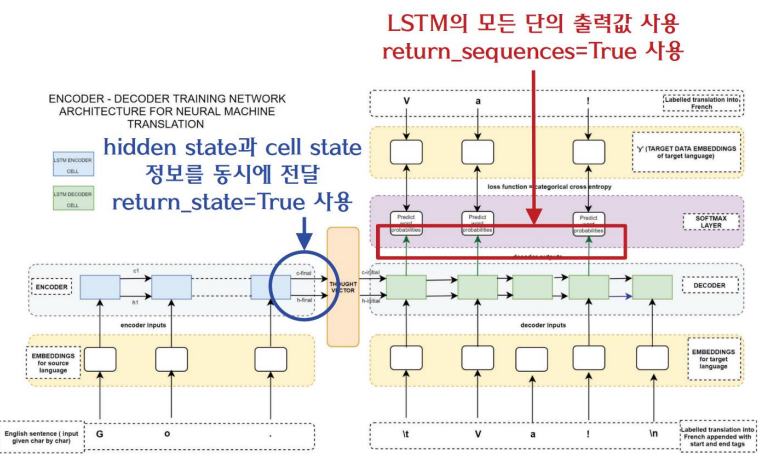

In [89]:
# 7. 모델 구현
# Encoder LSTM 구현
ENC_IN = Input(shape = (4, alpha_total_size))
# 출력, state_c, state_h
_, state_h, state_c = LSTM(units = MY_HIDDEN, # 128
                           return_state = True)(ENC_IN)
# Encoder와 Decoder 연결
link = [state_h, state_c]

# Decoder LSTM 구현
DEC_IN = Input(shape = (3, alpha_total_size))
DEC_MID = LSTM(units = MY_HIDDEN,
               return_sequences = True)(DEC_IN, initial_state = link)

# 최종 출력층
DEC_OUT = Dense(units = alpha_total_size,
                activation = 'softmax')(DEC_MID)

# 모델 구조 구현
# 병렬구조도 가능하도록 Model() 사용, Sequential()은 순차적 layer만 가능
model = Model(inputs  = [ENC_IN, DEC_IN],
              outputs = DEC_OUT)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 4, 171)]     0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 3, 171)]     0           []                               
                                                                                                  
 lstm_11 (LSTM)                 [(None, 128),        153600      ['input_14[0][0]']               
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [92]:
# 8. 학습과정 설정 및 학습하기
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy']
             ) # Seq2Seq에서는 rmsprop도 자주 사용
begin = time()
model.fit([X_enc, X_dec],
          Y_dec,
          epochs = MY_EPOCH,
          verbose = 1
         )
end = time()
print('학습 소요 시간:', end - begin, '초')

Epoch 1/500
4/4 [==============================] - 3s 11ms/step - loss: 5.8774e-07 - accuracy: 1.0000
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 5.8087e-07 - accuracy: 1.0000
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 5.7979e-07 - accuracy: 1.0000
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 5.7618e-07 - accuracy: 1.0000
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 5.7293e-07 - accuracy: 1.0000
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 5.6787e-07 - accuracy: 1.0000
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 5.7112e-07 - accuracy: 1.0000
Epoch 8/500
4/4 [==============================] - 0s 11ms/step - loss: 5.6570e-07 - accuracy: 1.0000
Epoch 9/500
4/4 [==============================] - 0s 11ms/step - loss: 5.6209e-07 - accuracy: 1.0000
Epoch 10/500
4/4 [==============================] - 0s 11ms/step - loss: 5.5812e-07

4/4 [==============================] - 0s 14ms/step - loss: 3.9556e-07 - accuracy: 1.0000
Epoch 81/500
4/4 [==============================] - 0s 11ms/step - loss: 4.0387e-07 - accuracy: 1.0000
Epoch 82/500
4/4 [==============================] - 0s 10ms/step - loss: 3.9881e-07 - accuracy: 1.0000
Epoch 83/500
4/4 [==============================] - 0s 10ms/step - loss: 3.8906e-07 - accuracy: 1.0000
Epoch 84/500
4/4 [==============================] - 0s 9ms/step - loss: 3.8653e-07 - accuracy: 1.0000
Epoch 85/500
4/4 [==============================] - 0s 10ms/step - loss: 3.8544e-07 - accuracy: 1.0000
Epoch 86/500
4/4 [==============================] - 0s 10ms/step - loss: 3.9014e-07 - accuracy: 1.0000
Epoch 87/500
4/4 [==============================] - 0s 11ms/step - loss: 3.8761e-07 - accuracy: 1.0000
Epoch 88/500
4/4 [==============================] - 0s 11ms/step - loss: 3.7966e-07 - accuracy: 1.0000
Epoch 89/500
4/4 [==============================] - 0s 11ms/step - loss: 3.7822e-07 - a

4/4 [==============================] - 0s 9ms/step - loss: 2.9875e-07 - accuracy: 1.0000
Epoch 160/500
4/4 [==============================] - 0s 10ms/step - loss: 2.9694e-07 - accuracy: 1.0000
Epoch 161/500
4/4 [==============================] - 0s 11ms/step - loss: 2.9513e-07 - accuracy: 1.0000
Epoch 162/500
4/4 [==============================] - 0s 6ms/step - loss: 2.9549e-07 - accuracy: 1.0000
Epoch 163/500
4/4 [==============================] - 0s 12ms/step - loss: 2.9658e-07 - accuracy: 1.0000
Epoch 164/500
4/4 [==============================] - 0s 7ms/step - loss: 2.9333e-07 - accuracy: 1.0000
Epoch 165/500
4/4 [==============================] - 0s 11ms/step - loss: 2.9549e-07 - accuracy: 1.0000
Epoch 166/500
4/4 [==============================] - 0s 10ms/step - loss: 2.9441e-07 - accuracy: 1.0000
Epoch 167/500
4/4 [==============================] - 0s 9ms/step - loss: 2.9260e-07 - accuracy: 1.0000
Epoch 168/500
4/4 [==============================] - 0s 9ms/step - loss: 2.8791e-0

Epoch 238/500
4/4 [==============================] - 0s 12ms/step - loss: 2.3625e-07 - accuracy: 1.0000
Epoch 239/500
4/4 [==============================] - 0s 11ms/step - loss: 2.3697e-07 - accuracy: 1.0000
Epoch 240/500
4/4 [==============================] - 0s 11ms/step - loss: 2.3589e-07 - accuracy: 1.0000
Epoch 241/500
4/4 [==============================] - 0s 10ms/step - loss: 2.3878e-07 - accuracy: 1.0000
Epoch 242/500
4/4 [==============================] - 0s 11ms/step - loss: 2.3625e-07 - accuracy: 1.0000
Epoch 243/500
4/4 [==============================] - 0s 10ms/step - loss: 2.3517e-07 - accuracy: 1.0000
Epoch 244/500
4/4 [==============================] - 0s 12ms/step - loss: 2.3119e-07 - accuracy: 1.0000
Epoch 245/500
4/4 [==============================] - 0s 12ms/step - loss: 2.2939e-07 - accuracy: 1.0000
Epoch 246/500
4/4 [==============================] - 0s 12ms/step - loss: 2.3083e-07 - accuracy: 1.0000
Epoch 247/500
4/4 [==============================] - 0s 11ms/ste

4/4 [==============================] - 0s 14ms/step - loss: 1.9471e-07 - accuracy: 1.0000
Epoch 317/500
4/4 [==============================] - 0s 10ms/step - loss: 1.9868e-07 - accuracy: 1.0000
Epoch 318/500
4/4 [==============================] - 0s 10ms/step - loss: 1.9724e-07 - accuracy: 1.0000
Epoch 319/500
4/4 [==============================] - 0s 10ms/step - loss: 1.9688e-07 - accuracy: 1.0000
Epoch 320/500
4/4 [==============================] - 0s 16ms/step - loss: 1.9615e-07 - accuracy: 1.0000
Epoch 321/500
4/4 [==============================] - 0s 11ms/step - loss: 1.9073e-07 - accuracy: 1.0000
Epoch 322/500
4/4 [==============================] - 0s 16ms/step - loss: 1.9073e-07 - accuracy: 1.0000
Epoch 323/500
4/4 [==============================] - 0s 10ms/step - loss: 1.9290e-07 - accuracy: 1.0000
Epoch 324/500
4/4 [==============================] - 0s 16ms/step - loss: 1.9146e-07 - accuracy: 1.0000
Epoch 325/500
4/4 [==============================] - 0s 11ms/step - loss: 1.88

4/4 [==============================] - 0s 11ms/step - loss: 1.6545e-07 - accuracy: 1.0000
Epoch 395/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6978e-07 - accuracy: 1.0000
Epoch 396/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6762e-07 - accuracy: 1.0000
Epoch 397/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6581e-07 - accuracy: 1.0000
Epoch 398/500
4/4 [==============================] - 0s 12ms/step - loss: 1.7195e-07 - accuracy: 1.0000
Epoch 399/500
4/4 [==============================] - 0s 11ms/step - loss: 1.6798e-07 - accuracy: 1.0000
Epoch 400/500
4/4 [==============================] - 0s 13ms/step - loss: 1.6364e-07 - accuracy: 1.0000
Epoch 401/500
4/4 [==============================] - 0s 16ms/step - loss: 1.6617e-07 - accuracy: 1.0000
Epoch 402/500
4/4 [==============================] - 0s 12ms/step - loss: 1.6220e-07 - accuracy: 1.0000
Epoch 403/500
4/4 [==============================] - 0s 12ms/step - loss: 1.62

Epoch 473/500
4/4 [==============================] - 0s 11ms/step - loss: 1.5136e-07 - accuracy: 1.0000
Epoch 474/500
4/4 [==============================] - 0s 11ms/step - loss: 1.4305e-07 - accuracy: 1.0000
Epoch 475/500
4/4 [==============================] - 0s 12ms/step - loss: 1.4630e-07 - accuracy: 1.0000
Epoch 476/500
4/4 [==============================] - 0s 12ms/step - loss: 1.4088e-07 - accuracy: 1.0000
Epoch 477/500
4/4 [==============================] - 0s 12ms/step - loss: 1.4739e-07 - accuracy: 1.0000
Epoch 478/500
4/4 [==============================] - 0s 11ms/step - loss: 1.4702e-07 - accuracy: 1.0000
Epoch 479/500
4/4 [==============================] - 0s 11ms/step - loss: 1.4522e-07 - accuracy: 1.0000
Epoch 480/500
4/4 [==============================] - 0s 11ms/step - loss: 1.4450e-07 - accuracy: 1.0000
Epoch 481/500
4/4 [==============================] - 0s 12ms/step - loss: 1.4269e-07 - accuracy: 1.0000
Epoch 482/500
4/4 [==============================] - 0s 11ms/ste

In [97]:
# 9. 모델 사용
test = [['cold', 'PP'],
        ['down', 'PP'],
        ['desk', 'PP'],
        ['love', 'PP'],
        ['olve', 'PP'], # love 변형
        ['lvoe', 'PP'], 
        ['loev', 'PP'],
        ['eovl', 'PP']]

enc_in, dec_in, dec_out = encoding(test)
enc_in = np.array(enc_in)
dec_in = np.array(dec_in)
# predict할 거니까 dec_out은 불필요
print(enc_in.shape, dec_in.shape)

(8, 4, 171) (8, 3, 171)


In [100]:
pred = model.predict([enc_in, dec_in])
pred

1/1 [==============================] - 0s 34ms/step


array([[[9.16343536e-15, 8.28929259e-20, 2.53521637e-14, ...,
         7.48158263e-13, 8.39518385e-12, 1.14645484e-08],
        [3.48474877e-14, 1.55197259e-08, 7.21440662e-14, ...,
         1.01341122e-08, 2.27118151e-12, 4.88073315e-09],
        [3.92451447e-19, 1.00000000e+00, 5.97153678e-19, ...,
         8.60212346e-13, 9.62242792e-20, 7.76158259e-16]],

       [[3.82472942e-15, 4.64172359e-18, 1.53390196e-14, ...,
         1.66133134e-12, 2.88854688e-13, 1.06553086e-10],
        [1.41457204e-14, 4.23620428e-09, 2.57866509e-14, ...,
         2.18194837e-11, 2.83382242e-14, 2.03877778e-12],
        [4.82606989e-18, 9.99998331e-01, 6.60950273e-18, ...,
         2.17753577e-13, 9.22671687e-19, 1.58788661e-16]],

       [[3.95228724e-14, 2.24143025e-21, 4.25248012e-14, ...,
         1.39769415e-14, 2.08503867e-10, 9.19934024e-14],
        [5.45514263e-13, 3.78080678e-10, 2.64786538e-13, ...,
         2.48558396e-10, 3.90031052e-13, 6.31423863e-12],
        [1.14264587e-11, 9.99999881e

In [101]:
# 8면 3행 171열
pred.shape

(8, 3, 171)

In [110]:
# alpha[32], char_to_num['감']
# 출력형식: cold → 감기(32, xx, 1)
for i in range(len(pred)):
    # test [0]방의 영어단어
    eng = test[i][0]
    # predict 결과
    hat = pred[i].argmax(axis = 1)
    # 숫자 ID를 한글로 변환
    kor = alpha[hat[0]] + alpha[hat[1]]
    print("{} → {}\npredict: {}\n".format(eng, kor, hat))

cold → 감기
predict: [32 46  1]

down → 아래
predict: [111  67   1]

desk → 책상
predict: [149  97   1]

love → 사랑
predict: [96 66  1]

olve → 사랑
predict: [96 66  1]

lvoe → 사랑
predict: [96 66  1]

loev → 사랑
predict: [96 66  1]

eovl → 도다
predict: [62 60  1]

